In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from scipy import ndimage, optimize
from scipy.fft import fft2, ifft2
import cv2
import scipy.constants as c
import pandas as pd
from IPython.display import display

import beam_caustic


# Time of Flight Analysis

In [2]:
def run_d4sigma(
    image: np.ndarray,
    *,
    pixel_size_x_mm: float = 8.4e-3,
    pixel_size_y_mm: float = 9.8e-6,
    self_conf_width: float = 3,
    bkg_ellipse_axes_scaling: float = 1.0,
    d4s_rel_tol: float | None = None,
    d4s_abs_tol: float = 1.0,
    debug_d4sigma: bool = False,
    make_fit_plots: bool = False,
    plot_label: str = "",
):
    """
    Analyze a single CCD sub-image (e.g., before-shutter or after-shutter region).

    Returns
    -------
    fit_dict : dict
        Parameters from the 2D Gaussian fit (from beam_caustic.fit_gaussian_2d).
    gaussian_model : callable
        Callable model gaussian_2d(*popt) that can be evaluated on coordinates.
    d4sigma_summary : dict
        Key results from the D4σ method.
    """

    # ----------------------------
    # 1) Estimate background region using an ellipse fit
    # ----------------------------
    xc_ell, yc_ell, minor_saxis_ell, major_saxis_ell, orientation_ell = beam_caustic.find_ellipse(image)

    ellipse_mask = beam_caustic.get_ellipse_mask(
        xc_ell, yc_ell,
        bkg_ellipse_axes_scaling * minor_saxis_ell,
        bkg_ellipse_axes_scaling * major_saxis_ell,
        orientation_ell,
        image.shape
    )

    # Background estimate from pixels *outside* the ellipse
    if np.any(~ellipse_mask):
        bkg_avg = float(image[~ellipse_mask].mean())
    else:
        # Fallback: if ellipse covers everything, assume zero background
        bkg_avg = 0.0

    image_bkg_corr = image.astype(float) - bkg_avg

    # ----------------------------
    # 2) Fit a 2D Gaussian (for center + waist estimates)
    # ----------------------------
    fit_result, fit_dict, gaussian_2d = beam_caustic.fit_gaussian_2d(
        image_bkg_corr,
        pstart=[
            image_bkg_corr.max(),
            xc_ell, yc_ell,
            minor_saxis_ell, major_saxis_ell,
            orientation_ell,
            0.0
        ],
    )

    # Convert (w0x, w0y) [pixels] -> 1/e^2 diameters in mm (matching your original)
    w_major_mm = 2 * fit_dict["w0x_Value"] * pixel_size_x_mm
    w_minor_mm = 2 * fit_dict["w0y_Value"] * pixel_size_y_mm

    # ----------------------------
    # 3) Run D4σ method (for ISO-style beam widths)
    # ----------------------------
    xc_d4s, yc_d4s, dx_d4s, dy_d4s, orientation_d4s, iterations_d4s, converged_d4s = (
        beam_caustic.run_d4sigma_method(
            image_bkg_corr,
            self_conf_width=self_conf_width,
            debug=debug_d4sigma,
            ignore_crop_error=True,
            rel_tol=d4s_rel_tol,
            abs_tol=d4s_abs_tol,
        )
    )

    d4sigma_summary = {
        "x0_px": float(xc_d4s),
        "y0_px": float(yc_d4s),
        "D4sigma_x_px": float(dx_d4s),
        "D4sigma_y_px": float(dy_d4s),
        "phi_deg": float(orientation_d4s),
        "iterations": int(iterations_d4s),
        "converged": bool(converged_d4s),
        "bkg_avg_cts": float(bkg_avg),
    }

    # ----------------------------
    # 4) Optional: diagnostic plots for this sub-image
    # ----------------------------
    if make_fit_plots:
        fig, axs = plt.subplots(1, 3, figsize=(14, 3.5), constrained_layout=True)
        fig.suptitle(f"2D Gaussian fit diagnostics {plot_label}".strip())

        image_fit = gaussian_2d(*fit_result["Popt"])(*np.flipud(np.indices(image_bkg_corr.shape)))
        images = [
            (image_bkg_corr, "Background-corrected"),
            (image_fit, "Gaussian fit"),
            (image_fit - image_bkg_corr, "Residual (fit - data)"),
        ]

        for ax, (im, title) in zip(axs, images):
            h = ax.imshow(im, cmap="gray")
            ax.set_title(title)
            ax.set_xlabel("x (px)")
            ax.set_ylabel("y (px)")
            plt.colorbar(h, ax=ax, fraction=0.046, pad=0.04)

        # Add a small text box with key numbers
        text = (
            f"x0={fit_dict['x0_Value']:.2f} px, y0={fit_dict['y0_Value']:.2f} px\n"
            f"w_major={w_major_mm:.3e} mm, w_minor={w_minor_mm:.3e} mm\n"
            f"D4σx={dx_d4s:.2f} px, D4σy={dy_d4s:.2f} px, converged={converged_d4s}"
        )
        axs[2].text(1.02, 0.5, text, transform=axs[2].transAxes, va="center")

    # Return raw fit dict + model, plus a compact D4σ summary
    return fit_dict, gaussian_2d, d4sigma_summary


In [ ]:
def get_params(filename: str, *, show_raw: bool = False, show_split: bool = True, make_fit_plots: bool = False):
    """
    Load a CCD text file, split into before/after shutter halves, and analyze both regions.

    Returns
    -------
    results : dict
        Contains per-region fit outputs and a small summary table.
    """
    fname = Path(filename).name

    # ---- Load CCD array (your file format: 3 header rows, then pixel values)
    pixel_array = np.loadtxt(filename, dtype=np.uint8, delimiter=None, skiprows=3)

    if show_raw:
        plt.figure(figsize=(6, 4))
        h = plt.imshow(pixel_array, cmap="gray", vmin=0, vmax=255)
        plt.colorbar(h, fraction=0.046, pad=0.04)
        plt.title(f"Raw CCD Image: {fname}")
        plt.xlabel("x (px)")
        plt.ylabel("y (px)")
        plt.show()

    # ---- Split into two halves (matching your original indexing)
    # Image shape seems to be (492, 384). You were taking:
    #   before_shutter: bottom half
    #   after_shutter:  top half
    ny, nx = pixel_array.shape
    mid = ny // 2

    after_shutter = pixel_array[0:mid-1, 0:nx]          # top half
    before_shutter = pixel_array[mid+1:ny-1, 0:nx]      # bottom half

    if show_split:
        fig, axs = plt.subplots(1, 2, figsize=(10, 3.5), constrained_layout=True)
        fig.suptitle(f"CCD halves: {fname}")

        # Keep the same scaling for easy comparison
        vmin, vmax = 0, 255
        h0 = axs[0].imshow(before_shutter, cmap="gray", vmin=vmin, vmax=vmax)
        axs[0].set_title(f"Before Shutter: {fname}")
        axs[0].set_xlabel("x (px)")
        axs[0].set_ylabel("y (px)")

        h1 = axs[1].imshow(after_shutter, cmap="gray", vmin=vmin, vmax=vmax)
        axs[1].set_title(f"After Shutter: {fname}")
        axs[1].set_xlabel("x (px)")
        axs[1].set_ylabel("y (px)")

        # One shared colorbar (matches the common scale)
        cbar = fig.colorbar(h1, ax=axs, fraction=0.046, pad=0.04)
        cbar.set_label("Counts (cts/px)")
        plt.show()

    # ---- Analyze each region
    regions = {
        "before_shutter": before_shutter,
        "after_shutter": after_shutter,
    }

    outputs = {}
    rows = []

    for region_name, region_img in regions.items():
        fit_dict, gaussian_model, d4sigma_summary = run_d4sigma(
            region_img,
            make_fit_plots=make_fit_plots,
            plot_label=f"({region_name}) {fname}",
        )

        # 1/e^2 diameter (mm), matching your earlier calculation
        pixel_size_x_mm = 8.4e-3
        pixel_size_y_mm = 9.8e-6
        waist_x_mm = 2 * fit_dict["w0x_Value"] * pixel_size_x_mm
        waist_y_mm = 2 * fit_dict["w0y_Value"] * pixel_size_y_mm

        outputs[region_name] = {
            "fit_dict": fit_dict,
            "gaussian_model": gaussian_model,
            "d4sigma": d4sigma_summary,
            "waist_x_mm": float(waist_x_mm),
            "waist_y_mm": float(waist_y_mm),
        }

        rows.append({
            "file": fname,
            "region": region_name,
            "x0_px": fit_dict["x0_Value"],
            "y0_px": fit_dict["y0_Value"],
            "waist_x_mm (2*w0x*px)": waist_x_mm,
            "waist_y_mm (2*w0y*py)": waist_y_mm,
            "D4sigma_x_px": d4sigma_summary["D4sigma_x_px"],
            "D4sigma_y_px": d4sigma_summary["D4sigma_y_px"],
            "phi_deg": d4sigma_summary["phi_deg"],
            "bkg_avg_cts": d4sigma_summary["bkg_avg_cts"],
            "d4sigma_converged": d4sigma_summary["converged"],
        })

    summary_df = pd.DataFrame(rows)

    return {
        "file": fname,
        "pixel_array": pixel_array,
        "regions": outputs,
        "summary_df": summary_df,
    }


In [10]:
def analyze_tof(tof_s: float, filename: str, *, make_fit_plots: bool = False, show_split: bool = True):
    """
    Compute TOF velocity and a (simple) temperature estimate from before/after shutter positions.

    Parameters
    ----------
    tof_s : float
        Time-of-flight in seconds.
    filename : str
        CCD file to analyze.
    make_fit_plots : bool
        If True, show Gaussian fit diagnostics per region.
    show_split : bool
        If True, show a side-by-side imshow of before vs after shutter.

    Returns
    -------
    results : dict
        vx, vy, Tx, Ty plus a compact per-file summary table.
    """
    out = get_params(filename, show_raw=False, show_split=show_split, make_fit_plots=make_fit_plots)

    # Pull out fitted centers (convert px -> meters using the same factor you had: *1e-3)
    # NOTE: If you have a more accurate px->meter conversion, swap it in here.

    pixel_size_x_mm = 8.4e-3
    pixel_size_y_mm = 9.8e-6

    before = out["regions"]["before_shutter"]["fit_dict"]
    after  = out["regions"]["after_shutter"]["fit_dict"]



    x_init_m  = before["x0_Value"] * 1e-3
    x_final_m = after["x0_Value"]  * 1e-3
    y_init_m  = before["y0_Value"] * 1e-3
    y_final_m = after["y0_Value"]  * 1e-3

    # waist_x_init = before['w0x_Value'] * 2 * pixel_size_x_mm * 1e-3
    # waist_y_init = before['w0y_Value'] * 2 * pixel_size_y_mm * 1e-3
    # waist_x_final = after["w0x_Value"] * 2 * pixel_size_x_mm * 1e-3
    # waist_y_final = after["w0y_Value"] * 2 * pixel_size_y_mm * 1e-3


    waist_x_init = out["regions"]["before_shutter"]['waist_x_mm'] * 2 * 1e-3
    waist_y_init = out["regions"]["before_shutter"]['waist_y_mm'] * 2 * 1e-3
    waist_x_final = out["regions"]["after_shutter"]['waist_x_mm'] * 2 * 1e-3
    waist_y_final = out["regions"]["after_shutter"]['waist_y_mm'] * 2 * 1e-3
    
    vx = (x_final_m - x_init_m) / tof_s
    vy = (y_final_m - y_init_m) / tof_s

    # Temperature estimate (keeping your original structure; adjust if you have a specific model)
    m_rb85 = 85 * c.atomic_mass
    Tx = m_rb85 * (waist_x_final**2 - waist_x_init**2) / (3 * c.k * tof_s**2)
    Ty = m_rb85 * (waist_y_final**2 - waist_y_init**2) / (3 * c.k * tof_s**2)

    # Nicely formatted per-file printout
    fname = Path(filename).name
    pretty = pd.DataFrame([{
        "file": fname,
        "tof (ms)": tof_s * 1e3,
        "vx (m/s)": vx,
        "vy (m/s)": vy,
        "Tx (uK)": Tx*1e6,
        "Ty (uK)": Ty*1e6,
    }])

    display(pretty.style.format({
        "tof (ms)": "{:.3f}",
        "vx (m/s)": "{:.3e}",
        "vy (m/s)": "{:.3e}",
        "Tx (uK)": "{:.3e}",
        "Ty (uK)": "{:.3e}",
    }))

    return {
        "file": fname,
        "vx": float(vx),
        "vy": float(vy),
        "Tx": float(Tx),
        "Ty": float(Ty),
        "fit_summary": out["summary_df"],
    }


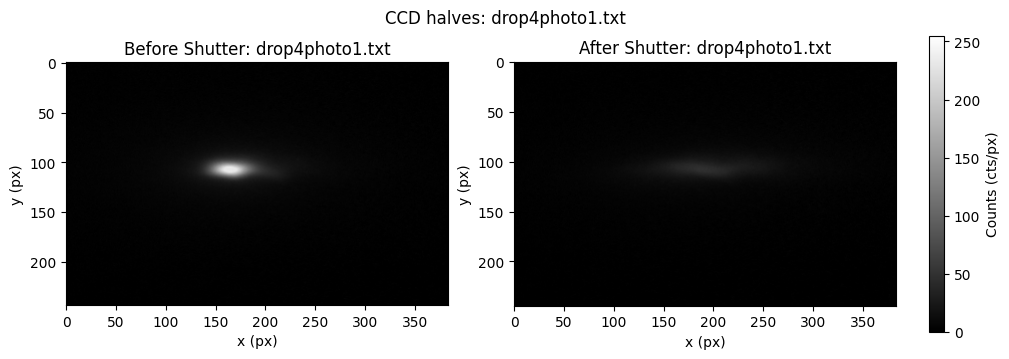

Error: Unable to determine beam parameters using moments, stopping
Error: Unable to determine beam parameters using moments, stopping


,file,tof (ms),vx (m/s),vy (m/s),Tx (uK),Ty (uK)
0,drop4photo1.txt,10.000,2.861e+00,-1.167e-01,4.178e+02,1.678e-05


,file,region,x0_px,y0_px,waist_x_mm (2*w0x*px),waist_y_mm (2*w0y*py),D4sigma_x_px,D4sigma_y_px,phi_deg,bkg_avg_cts,d4sigma_converged
0,drop4photo1.txt,before_shutter,165.20,107.03,5.685e-01,2.377e-04,nan,nan,24.42,2.71,False
1,drop4photo1.txt,after_shutter,193.82,105.87,1.841e+00,4.238e-04,188.44,nan,-3.52,1.45,False


In [11]:
# --- Single-file example
filename = "drop4photo1.txt"
res = analyze_tof(10e-3, filename, make_fit_plots=False, show_split=True)

# Show per-region fit summary for this file
display(res["fit_summary"].style.format({
    "x0_px": "{:.2f}",
    "y0_px": "{:.2f}",
    "waist_x_mm (2*w0x*px)": "{:.3e}",
    "waist_y_mm (2*w0y*py)": "{:.3e}",
    "D4sigma_x_px": "{:.2f}",
    "D4sigma_y_px": "{:.2f}",
    "phi_deg": "{:.2f}",
    "bkg_avg_cts": "{:.2f}",
}))


---


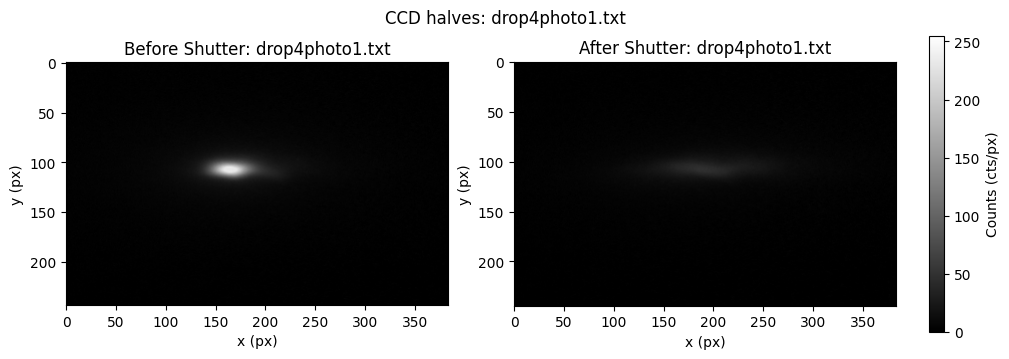

Error: Unable to determine beam parameters using moments, stopping
Error: Unable to determine beam parameters using moments, stopping


,file,tof (ms),vx (m/s),vy (m/s),Tx (uK),Ty (uK)
0,drop4photo1.txt,10.000,2.861e+00,-1.167e-01,4.178e+02,1.678e-05


In [12]:
params_dict = analyze_tof(10e-3, filename)

In [13]:
# --- Batch analysis across multiple files
filenames = ["drop4photo1.txt", "drop5photo1.txt", "droppic2.txt"]

batch_rows = []
for fn in filenames:
    r = analyze_tof(10e-3, fn, make_fit_plots=False, show_split=False)  # no plots in batch
    batch_rows.append({k: r[k] for k in ["file", "vx", "vy", "Tx", "Ty"]})

batch_df = pd.DataFrame(batch_rows)

display(batch_df.style.format({
    "vx": "{:.3e}",
    "vy": "{:.3e}",
    "Tx": "{:.3e}",
    "Ty": "{:.3e}",
}))


Error: Unable to determine beam parameters using moments, stopping
Error: Unable to determine beam parameters using moments, stopping


,file,tof (ms),vx (m/s),vy (m/s),Tx (uK),Ty (uK)
0,drop4photo1.txt,10.000,2.861e+00,-1.167e-01,4.178e+02,1.678e-05


Error: Unable to determine beam parameters using moments, stopping
Error: Unable to determine beam parameters using moments, stopping


,file,tof (ms),vx (m/s),vy (m/s),Tx (uK),Ty (uK)
0,drop5photo1.txt,10.000,2.397e+00,-9.171e-02,2.105e+02,7.467e-06


Error: Unable to determine beam parameters using moments, stopping
Error: Unable to determine beam parameters using moments, stopping


,file,tof (ms),vx (m/s),vy (m/s),Tx (uK),Ty (uK)
0,droppic2.txt,10.000,4.067e+00,-4.618e-01,2.025e+02,8.698e-06


,file,vx,vy,Tx,Ty
0,drop4photo1.txt,2.861e+00,-1.167e-01,4.178e-04,1.678e-11
1,drop5photo1.txt,2.397e+00,-9.171e-02,2.105e-04,7.467e-12
2,droppic2.txt,4.067e+00,-4.618e-01,2.025e-04,8.698e-12


## Atom number (calibration)

The 2D Gaussian fit gives a total camera signal  (in “camera counts”), not atoms by itself.
The most robust way to convert to atom number in this lab is to calibrate the camera integral to PD3:

1. For each image, compute a background-subtracted “Gaussian integral” $S_{\rm cam}$ from the fit.
2. For the same shot/time, compute the PD3 atom number $N_{\rm PD}$ from your voltage analysis.
3. Fit a line $N_{\rm PD} \approx \alpha S_{\rm cam} + \beta$ (often $\beta\approx 0$ if background subtraction is good).
4. Use $N \approx \alpha S_{\rm cam} + \beta$ to get atoms from camera images.

This avoids needing camera QE, gain, exact optics transmission, etc. All of that lives in $\alpha$.


In [16]:
import numpy as np

def gaussian_integral_from_fitdict(fit_dict: dict, *, subtract_offset: bool = True) -> float:
    """
    Returns the integrated Gaussian signal in 'camera units' (counts * pixels^2),
    using the 2D Gaussian model parameters from your fit_dict.

    Assumes model form:
        I(x,y) = Offset + Amplitude * exp( ... )
    with widths w0x, w0y (in pixels).

    Integral of Gaussian part (no offset):
        S = Amplitude * (2*pi*w0x*w0y)
    """
    # Required keys from your fitter output
    A = float(fit_dict["Amplitude_Value"])
    sx = float(fit_dict["w0x_Value"])
    sy = float(fit_dict["w0y_Value"])

    S = A * (2.0 * np.pi * sx * sy)

    # NOTE: subtract_offset doesn't change S here because we're integrating only the Gaussian term.
    # Offset subtraction matters if you instead integrate the *full image* over an ROI.
    return S


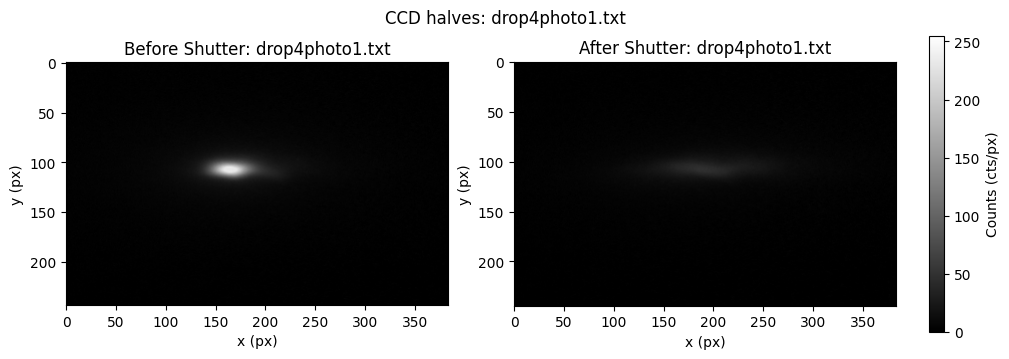

Error: Unable to determine beam parameters using moments, stopping
Error: Unable to determine beam parameters using moments, stopping
Fit dict keys (confirm amplitude/offset names):
['Amplitude_Sigma', 'Amplitude_Value', 'ChiSq', 'Error', 'Offset_Sigma', 'Offset_Value', 'Orientation_Sigma', 'Orientation_Value', 'RedChiSq', 'w0x_Sigma', 'w0x_Value', 'w0y_Sigma', 'w0y_Value', 'x0_Sigma', 'x0_Value', 'y0_Sigma', 'y0_Value']
S_cam (Gaussian integral, camera units) for after_shutter of drop4photo1.txt: 5.139e+05


In [17]:
# --- Example: compute camera integral for one file
filename = "drop4photo1.txt"
out = get_params(filename, show_raw=False, show_split=True, make_fit_plots=False)

region = "after_shutter"   # or "before_shutter"
fit_dict = out["regions"][region]["fit_dict"]

print("Fit dict keys (confirm amplitude/offset names):")
print(sorted(fit_dict.keys()))

S_cam = gaussian_integral_from_fitdict(fit_dict)
print(f"S_cam (Gaussian integral, camera units) for {region} of {filename}: {S_cam:.3e}")


In [18]:
def calibrate_camera_to_pd(
    filenames: list[str],
    N_pd: np.ndarray,
    *,
    region: str = "after_shutter",
    assume_intercept_zero: bool = True,
) -> dict:
    """
    Build a calibration mapping from camera Gaussian integral S_cam -> atom number N.

    filenames and N_pd must correspond to the SAME shots/times.
    """
    if len(filenames) != len(N_pd):
        raise ValueError("filenames and N_pd must have the same length")

    S_list = []
    for fn in filenames:
        out = get_params(fn, show_raw=False, show_split=False, make_fit_plots=False)
        fit_dict = out["regions"][region]["fit_dict"]
        S_list.append(gaussian_integral_from_fitdict(fit_dict))

    S = np.asarray(S_list, dtype=float)
    N_pd = np.asarray(N_pd, dtype=float)

    if assume_intercept_zero:
        alpha = float(np.dot(S, N_pd) / np.dot(S, S))
        beta = 0.0
    else:
        alpha, beta = np.polyfit(S, N_pd, deg=1)

    df = pd.DataFrame({"file": [Path(f).name for f in filenames], "S_cam": S, "N_pd": N_pd})
    return {"alpha": alpha, "beta": beta, "points": df, "region": region}

def camera_to_atoms(S_cam: float, alpha: float, beta: float = 0.0) -> float:
    return float(alpha * S_cam + beta)


In [30]:
# --- Calibration usage pattern (fill in your own filenames + PD-derived atom numbers)

calib_files = ["ManualSnapshot_39.txt"]
N_from_pd   = np.array([15098252])  # from your voltage notebook for those SAME shots

calib = calibrate_camera_to_pd(calib_files, N_from_pd, region="after_shutter", assume_intercept_zero=True)
print(f"alpha = {calib['alpha']:.3e} atoms / (camera-integral unit)")
display(calib["points"])

# Convert a new image:
out_new = get_params("drop4photo1.txt", show_raw=False, show_split=False, make_fit_plots=False)
S_new = gaussian_integral_from_fitdict(out_new["regions"]["after_shutter"]["fit_dict"])
N_est = camera_to_atoms(S_new, calib["alpha"], calib["beta"])
print("Estimated atom number from camera:", N_est)


2D Gaussian fit did not converge: Input must be 1- or 2-d.
Error: Unable to determine beam parameters using moments, stopping
alpha = 3.810e+01 atoms / (camera-integral unit)


,file,S_cam,N_pd
0,ManualSnapshot_39.txt,396257.908269,15098252.0


Error: Unable to determine beam parameters using moments, stopping


/Users/nadiathesun/Downloads/adinadia12826 MOT data/beam_caustic.py:170: RuntimeWarning: invalid value encountered in sqrt
  dx = 2*np.sqrt(2)*np.sqrt(xx+yy+(xx-yy)*np.sqrt(1+np.tan(2*orientation)**2))
/Users/nadiathesun/Downloads/adinadia12826 MOT data/beam_caustic.py:171: RuntimeWarning: invalid value encountered in sqrt
  dy = 2*np.sqrt(2)*np.sqrt(xx+yy-(xx-yy)*np.sqrt(1+np.tan(2*orientation)**2))


Error: Unable to determine beam parameters using moments, stopping
Estimated atom number from camera: 19579711.35365975


(492, 384)


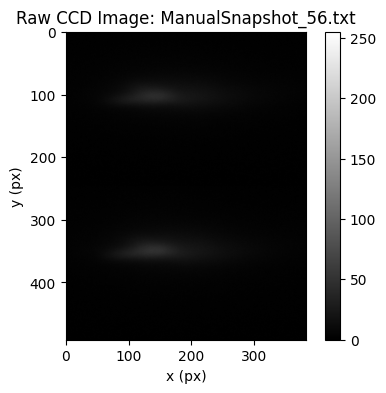

In [28]:
singleshot = np.loadtxt("ManualSnapshot_56.txt", dtype=np.uint8, delimiter=None, skiprows=3)

print(singleshot.shape)

plt.figure(figsize=(6, 4))
h = plt.imshow(singleshot, cmap="gray", vmin=0, vmax=255)
plt.colorbar(h, fraction=0.046, pad=0.04)
plt.title(f"Raw CCD Image: ManualSnapshot_56.txt")
plt.xlabel("x (px)")
plt.ylabel("y (px)")
plt.show()

